In [141]:
include("radial_basis_surrogates.jl")
using Plots

# Toy Problem in 1D
We'll fit a surrogate model to a simple function. Initially, we will have 2 known sample location and query 5 random location to then update our surrogate model at.

## Issues
The sign on the gradients seem to be incorrect. I suspect the issue is with the coefficients that are learned from the linear system
$$
c = K^{-1}y.
$$
If this is the case, how we compute the covariance matrix is the issue. When we densely sample and add gradient information for one location, our surrogate gets worse, suggesting that the mixed covariance matrix computation might indeed be the issue.

In [142]:
f(x; noise=0.) = cos(x)*x^2 + noise
∇f(x; noise=0.) = 2x*cos(x) -  x^2*sin(x) + noise

∇f (generic function with 1 method)

In [143]:
ψ = kernel_matern52()
X = collect(0:.75:2.)
X = reshape(X, 1, length(X))
∇xndx = length(X)
∇yndx = length(X) + 1
y = [f(first(X[:,j])) for j in 1:length(X)]
∇y = [∇f(first(X[:,j])) for j in ∇xndx:length(X)] 
yall = vcat(y, ∇y)
s = fit_surrogate(ψ, X, y)
ms = fit_multioutput_surrogate(ψ, X, yall; ∇xndx=∇xndx, ∇yndx=∇yndx);

In [149]:
gp_draw(s, [0.05]; stdnormal=randn())
# eval_KxX(s.ψ, [0.], s.X)

0.02191486702716762

In [113]:
Xu = rand(-3:.01:0, 1, 4)

for j in 1:length(Xu)
    xn = Xu[:,j]
    yn, ∇yn = f(first(xn)), [∇f(first(xn))]
    ms = update_multioutput_surrogate(ms, Xu[:,j], yn, ∇yn)
end

In [84]:
SAMPLES = 10
draws = []

for sample in 1:SAMPLES
    push!(draws, gp_draw(ms, [-.75]; stdnormal=randn(2)))
end

expected_grad = [draws[i][2][1] for i in 1:SAMPLES]
expected_grad = sum(expected_grad) / SAMPLES

-0.7141115007976061

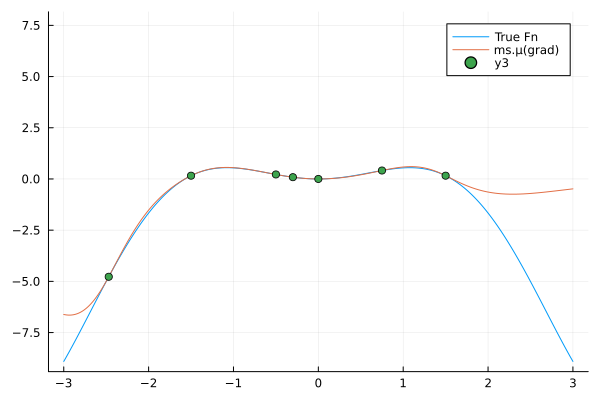

In [115]:
domain = -3:.01:3
plot(domain, f.(domain), label="True Fn")
# plot!(domain, ∇f.(domain), label="∇True Fn")
# scatter!(s.X', s.y, label=nothing)
# plot!(
#     domain,
#     [s([x]).μ for x in domain],
#     ribbons=2*[s([x]).σ for x in filter(x -> !(x in s.X), domain)],
#     label="s.μ"
# )
plot!(domain, [ms([x]).μ[1] for x in domain], label="ms.μ(grad)", linewidth=1)
# plot!(domain, [ms([x]).μ[2] for x in domain], label="∇μ(grad)", linewidth=1)
scatter!(ms.X', ms.y)

## Visualize Current State of Beliefs

## Update Beliefs at Deterministic Locations

In [ ]:
Xnew = [.2, 3.2, 3.9, -1.7, .9, 1.9]
Xnew = reshape(Xnew, 1, length(Xnew))
ynew = [first(f(Xnew[:,j])) for j in 1:size(Xnew, 2)]

for j = 1:size(Xnew, 2)
    s = update_surrogate(s, Xnew[:,j], f)
end

In [ ]:
domain = filter(x->!(x in s.X), domain)
scatter!(s.X', s.y, label="Observations")
plot!(domain,
    [s([x]).μ for x in domain],
    ribbons=2*[s([x]).σ for x in domain],
    label="(after) μ±2σ"
)